In [2]:
%%capture --no-stderr
%pip install -U langgraph langchain_community

In [3]:
!pip install -U langchain
!pip install -qU langchain-groq

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

# os.environ["OPENAI_API_KEY"]
# os.environ["LANGCHAIN_API_KEY"]
# os.environ["GROQ_API_KEY"]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "llama-8b-agent"

In [5]:
import json
import pandas as pd
import psycopg2
from typing import Annotated, Literal
import tempfile

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import AnyMessage, add_messages

# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    csv_path: str
    output_csv_path: str
    user_prompt: str

# Define a new graph
workflow = StateGraph(State)

# Add a node for loading the CSV file
def load_csv(state: State) -> dict:
    csv_path = state["csv_path"]
    
    try:
        df = pd.read_csv(csv_path, delimiter=",") 
    except Exception as e:
        return {"messages": [AIMessage(content=f"Error loading CSV: {str(e)}")]}
    
    # Store the DataFrame in the state, but not in `messages`
    return {
        "messages": [AIMessage(content=f"Loaded CSV with {df.shape[0]} rows and {df.shape[1]} columns.")],
        "df": df  # ✅ Store the DataFrame correctly in state
    }

workflow.add_node("load_csv", load_csv)

# Add a node for generating the Python script
def generate_python_script(state: State) -> dict[str, list[AIMessage]]:
    user_prompt = state["user_prompt"]

    # Strict system prompt to enforce pure Python code output
    python_script_prompt = f"""
    You are an AI assistant that generates Python scripts for data processing.
    
    - Your output must be a valid and executable Python script.
    - Do NOT include explanations, markdown formatting, or code block markers (e.g., ```Python ... ```).
    - The script must read a CSV file, process it according to the user's request, and write the output to a new CSV file.

    # Variables:
    input_csv_path = "{state['csv_path']}"  # Input CSV file path
    output_csv_path = "{state['output_csv_path']}"  # Output CSV file path
    
    Example task: "Apply logarithmic scaling to total_stakes and total_rewards."
    """

    chat_model = ChatGroq(model_name="llama3-8b-8192", temperature=0.0)
    response = chat_model.invoke(f"{python_script_prompt} User request: {user_prompt}")

    script_code = response.content 

    script_code = script_code.replace("```Python", "").replace("```", "").strip()

    if not script_code:
        return {"messages": [AIMessage(content="Error: Python script generation failed.")]}

    print("Generated script:\n", script_code)  # Debugging step

    return {
        "messages": [AIMessage(content=script_code)],
        #"python_script": script_code, 
    }

workflow.add_node("generate_python_script", generate_python_script)

# Add a node for executing the Python script
# should be similar to query_gen_node
def execute_python_script(state: State) -> dict[str, list[AIMessage]]:
#    if "python_script" not in state:
#        return {"messages": [AIMessage(content="Error: No Python script found in state.")]} 
    
    script_code = state["messages"][-1].content
    input_csv_path = state["csv_path"]
    output_csv_path = state["output_csv_path"]
    output_txt_path = output_csv_path.replace(".csv", ".txt")

    if not os.path.exists(input_csv_path):
        return {"messages": [AIMessage(content=f"Error: Input CSV file not found at {input_csv_path}.")]}

    try:
        with tempfile.NamedTemporaryFile(suffix=".py", delete=False) as temp_script:
            temp_script.write(script_code.encode("utf-8"))
            temp_script_path = temp_script.name
        
        # Execute the script
        exec_globals = {"__file__": temp_script_path, "input_csv_path": input_csv_path, "output_csv_path": output_csv_path}
        exec(open(temp_script_path).read(), exec_globals)

        if not os.path.exists(output_csv_path):
            return {"messages": [AIMessage(content="Error: Output CSV file was not created.")]}
        
        # Load the newly generated CSV
        df = pd.read_csv(output_csv_path)
        
        # Generate column descriptions
        column_descriptions = []
        for col in df.columns:
            dtype = df[col].dtype
            sample_values = df[col].dropna().sample(min(3, len(df)), random_state=42).tolist() if not df[col].isna().all() else []
            column_descriptions.append(f"{col}")
            #({dtype}): Sample values -> [sample_values]")

        # Write descriptions to a TXT file
        with open(output_txt_path, "w") as txt_file:
            txt_file.write("\n".join(column_descriptions))

        return {
            "messages": [AIMessage(content=f"Python script executed successfully. Processed data saved to {output_csv_path}. Column descriptions saved to {output_txt_path}.")], 
            "output_csv_path": output_csv_path,
            "output_txt_path": output_txt_path
        }
    
    except Exception as e:
        return {"messages": [AIMessage(content=f"Error executing script: {str(e)}")]}  

workflow.add_node("execute_python_script", execute_python_script)

# Define workflow edges
workflow.add_edge(START, "load_csv")
workflow.add_edge("load_csv", "generate_python_script")
workflow.add_edge("generate_python_script", "execute_python_script")
workflow.add_edge("execute_python_script", END)

# Compile workflow
app = workflow.compile()

### Visualize the graph

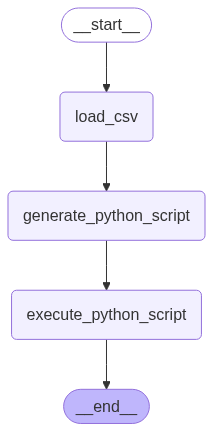

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run the agent

In [ ]:
# Define input and output CSV file paths
input_csv_path = "./second_graph_output_orange.csv"  
output_csv_path = "./second_graph_output_green.csv" 
user_prompt = '''
Generate a script in Python to create a smooth regression line (green line) for plotting, based on raw pool stakes and rewards data from a CSV file. The script should produce data points for a linear regression line in the original scale, suitable for a log-log plot of pool stakes vs. pool rewards. Follow these steps:

1. Load the CSV file from the specified input path into a pandas DataFrame. The CSV contains columns 'log_stakes' and 'log_rewards', representing raw pool stakes and rewards in their logarithmic scale.
2. Perform a linear regression of 'log_rewards' on 'log_stakes' using scipy.stats.linregress to obtain the slope and intercept.
3. Generate a smooth range of 100 'total_stakes' values, spanning from the minimum to the maximum of 'total_stakes' in the original scale, to align with the logarithmic x-axis of the plot.
4. Predict the corresponding 'log_rewards' using the regression slope and intercept, then exponentiate these values (using 10**x) to obtain 'predicted_rewards' in the original scale (results from calculating 10**(slope * np.log10(bins) + intercept)).
5. Calculate the slope and interception for the linear regression and print them out in the script.
6. Create a DataFrame with two columns: 'total_stakes' and 'predicted_rewards' (results from calculating 10**(slope * np.log10(bins) + intercept)). Save this DataFrame to the specified output CSV path without including intermediate columns (e.g., logarithmic values).
7. Include basic error handling: if the input DataFrame is empty or has fewer than 2 valid rows after filtering, print an error message and exit without saving the output CSV.

The script should use pandas, numpy, and scipy.stats. Ensure the output CSV is saved to the specified path with floating-point values rounded to 6 decimal places for consistency. The input and output CSV paths will be provided as variables 'input_csv_path' and 'output_csv_path'.

This script generates data for a green linear regression line, matching the line in a log-log scatter plot of pool stakes (x-axis) vs. pool rewards (y-axis), fitted to the raw data.

'''
#"Process the raw data to calculate the median pool rewards per bin based on logarithmic binning of pool stakes. Use log-spaced bins to cover the full range of stake values. For each bin, compute the median reward of the corresponding stake values. Output the bin centers and the corresponding median rewards as a structured dataset for plotting."

# Initialize the workflow state
state = {
    "messages": [],
    "csv_path": input_csv_path,
    "output_csv_path": output_csv_path,
    "user_prompt": user_prompt
}

result = app.invoke(state)
print(result["messages"][-1].content) 

Generated script:
 import pandas as pd
import numpy as np
from scipy.stats import linregress
import csv

input_csv_path = "/Users/yangxiaotong/Documents/UZH/HS2024/MA_Thesis/gemma/second_graph_output_orange.csv"
output_csv_path = "/Users/yangxiaotong/Documents/UZH/HS2024/MA_Thesis/llama3-8b/second_graph_output_green.csv"

df = pd.read_csv(input_csv_path)

if df.empty or len(df) < 2:
    print("Error: Input DataFrame is empty or has fewer than 2 valid rows.")
    exit()

slope, intercept, _, _, _ = linregress(df['log_stakes'], df['log_rewards'])

bins = np.logspace(np.log10(df['total_stakes'].min()), np.log10(df['total_stakes'].max()), 100)
predicted_rewards = 10**(slope * np.log10(bins) + intercept)

output_df = pd.DataFrame({'total_stakes': bins, 'predicted_rewards': predicted_rewards})

output_df.to_csv(output_csv_path, float_format='%.6f', index=False)
Python script executed successfully. Processed data saved to /Users/yangxiaotong/Documents/UZH/HS2024/MA_Thesis/llama3-8b/second_gra

In [30]:
print('Slope:', slope, 'Intercept', intercept)

Slope: 0.5208902865461373 Intercept 4.111779635153686
